In [6]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import h5py
from sklearn.linear_model import LinearRegression


import utils as utl

In [7]:
# sample rates
r_stim, r_rec = 2e5, 3.048

# path to folder
parent_dir = Path(r'\\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico')

# selection rule: all ROI.csv files 
p_csvs = [*parent_dir.glob('Gr5aLexA_opChrimsonR_*/**/ROI.csv')]

# maximum number of stims
n_max = 4

# generate quality control plots or not
plot = True

# collect all data in this file
p_out =  Path('./stim')
p_data = p_out / 'optfiber.pickle'

# preprocessing

In [8]:
# loop over als ROI.csv
l = []
for p_csv in p_csvs:

    # workdir
    p_dir = p_csv.parent

    # check for h5 file
    l_hpf = [ *p_dir.glob('*.h5') ]
    if len(l_hpf) != 1:
        print(f'INFO: directory must contain exactly one h5 file, skipping {p_dir}')
        continue
    p_hdf = l_hpf[0]

    # load data from csv file
    print('INFO: now parsing {}'.format(p_csv))
    df_rec = pd.read_csv(p_csv)
    f_rec_max = len(df_rec)

    # load data from h5 file
    print('INFO: now parsing {}'.format(p_hdf))
    with h5py.File(p_hdf, 'r') as f:
        stim = f['stim'][:]
        f_stim_on, f_stim_max = utl.get_onsets(stim, r_stim, r_rec, n_max=n_max)
        f_stim_on = f_stim_on - f_stim_max + f_rec_max

    # get additional info from file path
    n_fly = int(''.join(filter(str.isdigit, p_dir.parts[-2])))
    exp = p_dir.parts[-3]
    s = p_dir.parts[-1].split('_')
    n_trial = int(s[0].replace('trial', '')) 
    freq = float(s[1])
    

    fs, rois, intens = [], [], []
    f_rec = df_rec.loc[:, ' '].values - 1

    # reorder: background is now first ROI
    cols =  df_rec.columns[-1:].tolist() + df_rec.columns[1:-1].tolist() 

    # loop over ROIs and stims 
    for i, col in enumerate(cols):
        for j in f_stim_on:
            fs.extend(f_rec - j)
            intens.extend(df_rec.loc[:, col].values)
            rois.extend([i] * len(f_rec))

    # collect in data frame
    df = pd.DataFrame(data={
        'frame': fs,
        't': [ i / r_rec for i in fs ],
        'int': intens,
        'roi': rois,
        'exp': exp,
        'fly': n_fly,
        'trial': n_trial,
        'freq': freq,
    })

    # generate quality control plots
    if plot:
        fig, ax = plt.subplots(figsize=(15, 5))
        for col in df_rec.columns[1:]:

            y = df_rec.loc[:, col].values
            x = np.arange(len(y)) / r_rec

            ax.plot(x, y, label=col)

        y = stim
        x = np.arange(len(y)) / r_stim - f_stim_max / r_rec + f_rec_max / r_rec
        ax.plot(x, y, color='gray')

        ax.legend()

        for f in f_stim_on:
            t = f / r_rec
            ax.axvline(t, color='gray')

        ax.set_title(f'{freq}')
        ax.set_xlabel('time [s]')
        ax.set_ylabel('fluorescence')

        fig.tight_layout()
        
        fig.savefig(p_csv.with_suffix('.png'))

        plt.close(fig)

    l.append(df)

# combine dataframes
df_all = pd.concat(l, ignore_index=True)

# add short exp names
exps = df_all.loc[:, 'exp'].unique()
exp_dict = { a: b for a, b in zip(exps, 'abcdefghijklmnop') }
df_all.loc[:, 'exp_'] = df_all.loc[:, 'exp'].map(exp_dict)
df_all

# write to disk
df_all.to_pickle(p_data)

# print contents of df_all
for k in df_all.groupby(['exp', 'fly', 'trial', 'freq', 'roi']).groups.keys():
    print(f'exp: {k[0]}', f'fly: {k[1]}', f'trial {k[2]}', f'freq {k[3]}', f'roi {k[4]}')

INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female10\trial1_0.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female10\trial1_0.5\log_00005.h5
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female10\trial1_1\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female10\trial1_1\log_00006.h5
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female10\trial1_1.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female10\trial1_1.5\log_00007.h5


C:\Users\spillern\AppData\Local\Temp\ipykernel_17028\4123557779.py:84: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female10\trial2_1.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female10\trial2_1.5\log_00008.h5


C:\Users\spillern\AppData\Local\Temp\ipykernel_17028\4123557779.py:84: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female11\trial1_0.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female11\trial1_0.5\log_00009.h5
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female11\trial1_1\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female11\trial1_1\log_00010.h5
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female11\trial1_1.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female11\trial1_1.5\log_00011.h5
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female11\trial2_1.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\f

C:\Users\spillern\AppData\Local\Temp\ipykernel_17028\4123557779.py:84: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female12\trial1_0.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female12\trial1_0.5\log_00005.h5
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female12\trial1_1\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female12\trial1_1\log_00006.h5
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female12\trial1_1.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female12\trial1_1.5\log_00007.h5
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\female12\trial2_1.5\ROI.csv
INFO: now parsing \\mpfi.org\public\sb-lab\Nino_2P_for_Salil\for_Nico\Gr5aLexA_opChrimsonR_BB_GC7b\f

# analysis
## background subtraction and align to pre-stim

In [9]:
# load preprocessed data
df_all = pd.read_pickle(p_data)

# cycle through trials and ROIs
for k, df in df_all.groupby(['exp', 'fly', 'freq', 'trial', 'roi']):
    
    # expand group key
    exp, fly, f, t, r = k

    if r == 0: # get background (ROIs where reordered in preprocessing)
        y0 = df.loc[:, 'int'].values
        
    else: # r != 0 are ROIs
        y = df.loc[:, 'int'].values - y0 # subtract background

        x = df.loc[:, 't'].values # get values for f0
        mask = (x > -3) & (x < 0)

        # if mask.sum() != 9: # disregard misaligned
        #     continue

        # subtract pre-stim mean
        y -= y[mask].mean()
        if np.any(y != y):
            y
        df_all.loc[df.index, 'int_norm'] = y

        # zscore
        y = ( y - y.mean() ) / y.std()
        y -= y[mask].mean()
        df_all.loc[df.index, 'int_norm_z'] = y

## example exp, fly, roi

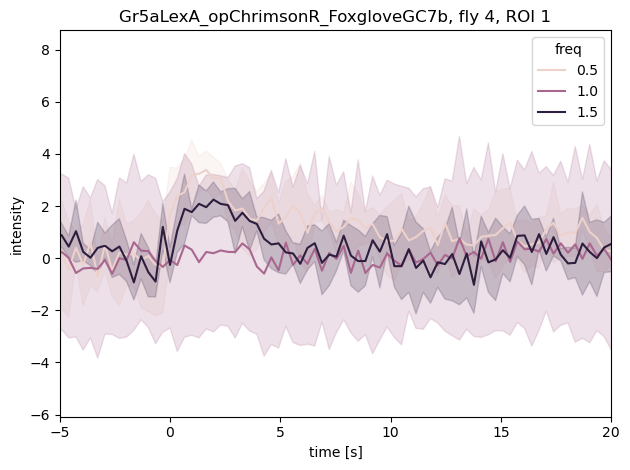

In [10]:
# plot example data: compare frequencies
exp, fly, roi = 'Gr5aLexA_opChrimsonR_FoxgloveGC7b', 4, 1

df = df_all.groupby(['exp', 'fly', 'roi']).get_group((exp, fly, roi))

fig, ax = plt.subplots()
sns.lineplot(ax=ax, data=df, x='t', y='int_norm', hue='freq', errorbar='sd')

ax.set_xlim(-5, 20)
ax.set_ylabel('intensity')
ax.set_xlabel('time [s]')
ax.set_title('{}, fly {}, ROI {}'.format(exp, fly, roi))

fig.tight_layout()
fig.savefig(p_out / 'freq.svg')

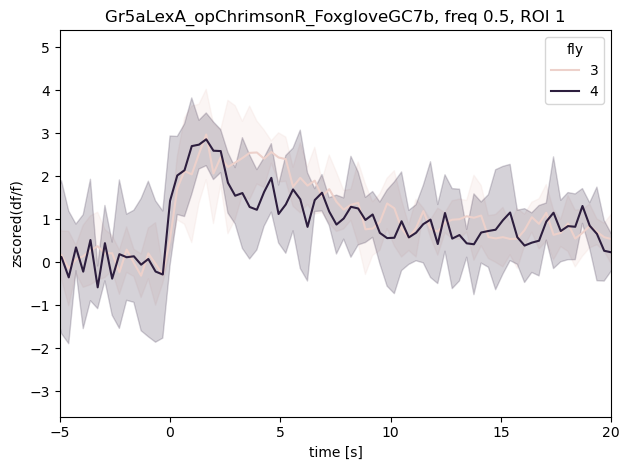

In [12]:
# plot example data: compare flies
exp, roi, freq = 'Gr5aLexA_opChrimsonR_FoxgloveGC7b', 1, 0.5

df = df_all.groupby(['exp', 'freq', 'roi']).get_group((exp, freq, roi))

fig, ax = plt.subplots()
sns.lineplot(ax=ax, data=df, x='t', y='int_norm_z', hue='fly', errorbar='sd')

ax.set_xlim(-5, 20)
ax.set_ylabel('zscored(df/f)')
ax.set_xlabel('time [s]')
ax.set_title('{}, freq {}, ROI {}'.format(exp, freq, roi))

fig.tight_layout()
fig.savefig(p_out / 'fly.svg')

## calculate area under the curve

In [15]:
# calculate area for (i) int (ii) int_norm (iii) int_norm_z
l = ['exp', 'exp_', 'fly', 'freq', 'trial', 'roi']
gr_all = df_all.groupby(l)

df_a = pd.DataFrame(columns=l)

for i, (k, df) in enumerate(gr_all):
    df_a.loc[i, l] = k

    x = df.loc[:, 't'].values
    mask = (x >= 0) & (x <= 2)
    
    y = df.loc[:, 'int'].values
    a1 = np.trapz(y[mask], x=x[mask])

    y = df.loc[:, 'int_norm'].values
    a2 = np.trapz(y[mask], x=x[mask])

    y = df.loc[:, 'int_norm_z'].values
    a3 = np.trapz(y[mask], x=x[mask])

    df_a.loc[i, ['area', 'area_norm', 'area_norm_z'] ] = a1, a2, a3

df_a.loc[:, 'freq_'] = df_a.loc[:, 'freq'].astype(float)
df_a = df_a.dropna()
df_a

,exp,exp_,fly,freq,trial,roi,area,area_norm,area_norm_z,freq_
1,Gr5aLexA_opChrimsonR_BB_GC7b,a,8,0.5,1,1,11.083333,5.145560,4.772137,0.5
2,Gr5aLexA_opChrimsonR_BB_GC7b,a,8,0.5,1,2,5.940945,2.395287,2.632945,0.5
4,Gr5aLexA_opChrimsonR_BB_GC7b,a,8,1.0,1,1,1.207677,3.217301,3.291429,1.0
5,Gr5aLexA_opChrimsonR_BB_GC7b,a,8,1.0,1,2,-3.185203,1.310914,1.616594,1.0
7,Gr5aLexA_opChrimsonR_BB_GC7b,a,8,1.5,1,1,9.138780,-0.960739,-1.049401,1.5
8,Gr5aLexA_opChrimsonR_BB_GC7b,a,8,1.5,1,2,7.634514,-0.003828,-0.004819,1.5
10,Gr5aLexA_opChrimsonR_BB_GC7b,a,10,0.5,1,1,6.713747,2.597878,2.541118,0.5
11,Gr5aLexA_opChrimsonR_BB_GC7b,a,10,0.5,1,2,9.166010,2.307688,1.976005,0.5
13,Gr5aLexA_opChrimsonR_BB_GC7b,a,10,1.0,1,1,18.164370,-1.613572,-1.823989,1.0
14,Gr5aLexA_opChrimsonR_BB_GC7b,a,10,1.0,1,2,26.236385,1.760280,1.905544,1.0


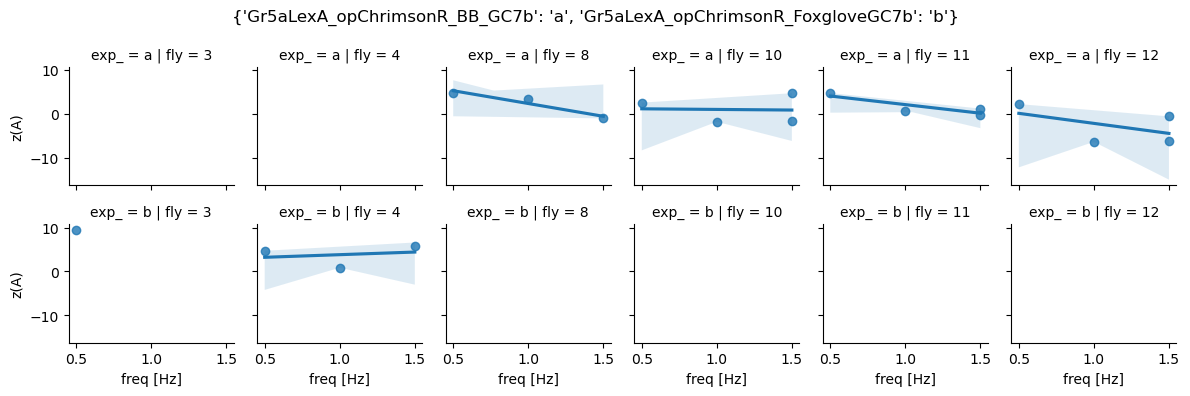

In [16]:
# individual flies
roi = 1

df_roi = df_a.groupby('roi').get_group(roi)
g = sns.lmplot(data=df_roi , height=2, 
        x='freq_', y='area_norm_z', col='fly', row='exp_', palette='tab10')
g.set_axis_labels('freq [Hz]', 'z(A)')
g.fig.suptitle(exp_dict)
g.tight_layout()

## Fit line

In [17]:
l = ['exp', 'exp_', 'roi']
gr = df_a.groupby(l)

df_f = pd.DataFrame(columns=l)
for i, (k, df) in enumerate(gr):

    df_f.loc[i, l] = k

    x = df.loc[:, 'freq'].values.reshape(-1, 1)
    y = df.loc[:, 'area_norm_z'].values
    reg = LinearRegression()
    reg.fit(x, y)
    df_f.loc[i, 'slope'] = reg.coef_
    df_f.loc[i, 'intercept'] =reg.intercept_
    df_f.loc[i, 'r2'] = reg.score(x, y)

df_f

,exp,exp_,roi,slope,intercept,r2
0,Gr5aLexA_opChrimsonR_BB_GC7b,a,1,-3.713774,4.500073,0.204127
1,Gr5aLexA_opChrimsonR_BB_GC7b,a,2,-0.306031,2.862069,0.008783
2,Gr5aLexA_opChrimsonR_FoxgloveGC7b,b,1,-2.243004,7.215177,0.090099
3,Gr5aLexA_opChrimsonR_FoxgloveGC7b,b,2,-3.786783,10.532523,0.115385


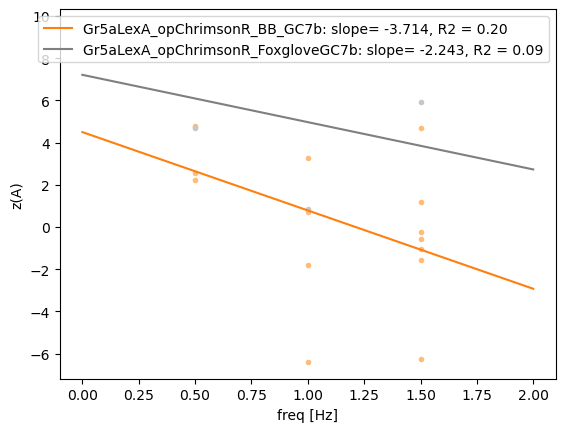

In [18]:
# select ROI
roi = 1

# color mapping for tab20
c_dict = {1: 7, 2: 4, 0: 1, 3: 3}
cmap = plt.get_cmap('tab20')

fig, ax = plt.subplots()
gr_a = df_a.groupby('roi').get_group(roi).groupby('exp')

df_f_roi = df_f.groupby('roi').get_group(roi)
for i, (e, df) in enumerate(df_f_roi.groupby('exp')):
    i = c_dict[i]
    
    a, b, r2 = df.loc[:, ['slope', 'intercept', 'r2']].values[0]
    y = lambda x: a*x + b

    # frequency
    # x = np.linspace(0, 100)
    
    # opt fiber
    x = np.linspace(0, 2)

    ax.plot(x, y(x), color=cmap(2*i), label='{}: slope= {:.3f}, R2 = {:.2f}'.format(e.split('-')[-1], a, r2))

    df = gr_a.get_group(e)
    x = df.loc[:, 'freq'].values
    y = df.loc[:, 'area_norm_z'].values
    ax.scatter(x, y, color=cmap(2*i + 1), marker='.')


ax.set_ylabel('z(A)')
ax.set_xlabel('freq [Hz]')
ax.legend()
fig.savefig(p_out / 'area_avg.svg')